# Fake News Detection Model

We will apply all the steps of the Machine Learning Lifecycle to a real-world project:
1. [Scoping](#scoping)
2. [Data](#data)
3. [Modeling](#modelling)
4. [Deployment](#deployment)

<a id='scoping'></a>
## 1. Scoping

A media monitoring organization wants to help users identify potentially unreliable news content across social media and web sources. The goal is to build a model to flag suspicious articles, then deploy it to serve their users' needs.

Before diving into building the system, we first need to gather some details about the project. This information will help guide our decisions and set expectations for all the stakeholders.

* **Identify a business problem** - The organization needs a fake news classifier to help users make informed decisions about content reliability. We'll want to identify the relevant business metrics and determine if the technology can indeed help improve those metrics. In this case, an ML model can help scale up the organization's ability to flag potentially unreliable content as misinformation spreads rapidly online. Manual fact-checking can't keep up with the velocity of content creation, and simple keyword-based filters have proven insufficient for detecting sophisticated misinformation.
* **Brainstorm AI solutions** - We'll develop an AI solution that classifies articles as reliable or potentially misleading using text features. Typically, as a team, we would want to brainstorm different solutions to see which one addresses the business problem most effectively.
* **Assess the feasibility and value of potential solutions** - Here, we would ask questions about the data labeling process, the definitions used for "fake news," etc. To assess project ethics, we would discuss the organization's commitment to transparency, fairness, and avoiding censorship of legitimate dissenting voices. 
* **Determine milestones and budget for resourcing** - We first would need to identify the metrics for success (precision, recall, F1-score, and fairness metrics across different content types) and estimate the time and resources needed to carry out the project. For now, we want to understand ML's capabilities and limitations in this sensitive domain by building a prototype model. This will help us estimate future timelines and assess whether a robust, production-ready system is achievable with the available data and resources.

<a id='data'></a>
## 2. Data

The quality of the data is critical. In many cases, a data-centric approach where the model code is held fixed and the data are improved iteratively results in better model performance.

In [2]:
# Packages needed for data preparation and modelling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import InputExample, InputFeatures

# Set working folders
BASE_DIR = './E1'
data_dir = './data'
model_dir = f'{BASE_DIR}/model'

print(
    f'data: {data_dir}\n'
    f'model: {model_dir}\n'
)

data: ./data
model: ./E1/model



Let's look at the available data and see if it's sufficient for the application. The full dataset is in the `data` folder. We will load the datasets into Pandas dataframes so we can preview and manipulate them later.

The dataset is called the WELFake dataset which can be downloaded from Kaggle: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

It is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training.

Dataset contains four columns:
* `Serial number (starting from 0)`
* `Title` - about the text news heading
* `Text` - about the news content
* `Label` - 0 = fake and 1 = real

In [3]:
# Set the column width in case we want to see the entire length of the `text` column
#pd.set_option('display.max_colwidth', None)

# Load the datasets into dataframes
all_data = pd.read_csv(f'{data_dir}/WELFake_Dataset.csv')

# Drop missing values
all_data = all_data.dropna()

# Drop duplicates in text
all_data = all_data.drop_duplicates(subset=['text'])

# Split the combined dataset to 70% train, 15% dev, and 15% test set. Produce a balanced split along the `label` column.
train_df, test_df = train_test_split(all_data, test_size=0.3, stratify=all_data['label'], random_state=3)
test_df, dev_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=3)

# Check label distribution
print(train_df['label'].value_counts(dropna=False, normalize=True))

# Preview the first 10 rows of the training set
train_df[:10]

label
0    0.556592
1    0.443408
Name: proportion, dtype: float64


,Unnamed: 0,title,text,label
57023,57023,China defends its right to 'ready slingshot' i...,BEIJING (Reuters) - China defended its right o...,0
33109,33109,OBAMA ADMINISTRATION Sues Private Business For...,The Obama EEOC has spiraled out of control to ...,1
27407,27407,France gets serious over sexual harassment aft...,PARIS (Reuters) - The Harvey Weinstein scandal...,0
38611,38611,Look How Differently President Obama And Dona...,There are many differences between GOP Preside...,1
19819,19819,Cummings And Chaffetz Reveal ‘MAJOR PROBLEM’ ...,Reps. Jason Chaffetz (R-UT) and Elijah Cumming...,1
4343,4343,Trump Lashes Out At Black CEO For Resigning F...,Donald Trump s stunning neglect to disavow the...,1
38073,38073,Wells Fargo to Claw Back $75 Million From 2 Fo...,Wells Fargo’s board said on Monday that it wou...,0
48783,48783,Putin-Trump meeting not yet planned for Asia s...,MOSCOW (Reuters) - Russian President Vladimir ...,0
65479,65479,Muslims in Kashmir observe martyrdom anniv. of...,Muslims in Kashmir observe martyrdom anniv. of...,1
1411,1411,"U.N. condemns anti-gay crackdowns in Egypt, Az...","GENEVA (Reuters) - Azerbaijan, Egypt and Indon...",0


### Define the Data

Preparing the data effectively is key to good model performance. If the human labelers providing the dataset's ground truth were given ambiguous labeling instructions, they might produce inconsistent labels. This is especially critical for fake news detection, where the line between misleading, biased, satirical, and outright false content can be subjective. These inconsistent labels make it harder for the learning algorithm to understand the relationship between the inputs and outputs, and can lead to a model that reflects labeller biases rather than objective indicators of misinformation.
Here are some questions about the data that might be sources of ambiguity:
  * <i>How were the labels determined? How many labellers were involved and how were their outputs aggregated? What is the inter-rater reliability? Were fact-checkers used, or was labeling based on source reputation? What was the threshold for labeling something as "fake" versus "misleading" versus "biased but factual"?
  * <i>How is "fake news" defined in this dataset? Does it include satire? Opinion pieces? Misleading headlines with accurate body text? Unverified claims?
  * <i> What is the class distribution? Is there significant class imbalance between fake and real news?
  * <i>Are the text features really enough for this application? If the dataset were to be collected again, what additional features might be useful?
  * <i>Are there potential sources of bias in the dataset? Does the dataset represent a balanced view of political perspectives? Are certain topics or sources overrepresented? Could the model learn to flag content based on political leaning rather than factual accuracy?
  * <i>What is the temporal distribution of the data? Misinformation tactics evolve over time. Is the training data recent enough to capture current patterns?

### Tokenize the Text, and Split the Data into Train, Development, Test Sets

In [4]:
# Load the Tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # distilbert is faster than bert

# Function to convert DataFrame rows to InputExamples
def convert_data_to_examples(df, text_column, label_column):
    return [
        InputExample(guid=None, text_a=row[text_column], text_b=None, label=row[label_column])
        for _, row in df.iterrows()
    ]

# Convert InputExamples to InputFeatures
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=512):
    features = []
    for e in examples:
        inputs = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        
        features.append(
            InputFeatures(
                input_ids=input_ids,
                attention_mask=attention_mask,
                label=int(e.label),
            )
        )
    
    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )
    
    return tf.data.Dataset.from_generator(
        gen,
        ({'input_ids': tf.int32, 'attention_mask': tf.int32}, tf.int64),
        (
            {
                'input_ids': tf.TensorShape([None]),
                'attention_mask': tf.TensorShape([None]),
            },
            tf.TensorShape([])
        )
    )

# Convert Train/Dev/Test Dataframes
train_examples = convert_data_to_examples(train_df, 'text', 'label')
dev_examples = convert_data_to_examples(dev_df, 'text', 'label')
test_examples = convert_data_to_examples(test_df, 'text', 'label')

# Convert to TensorFlow Datasets
train_dataset = convert_examples_to_tf_dataset(train_examples, tokenizer).shuffle(100).batch(16)
dev_dataset = convert_examples_to_tf_dataset(dev_examples, tokenizer).batch(16)
test_dataset = convert_examples_to_tf_dataset(test_examples, tokenizer).batch(16)

# Prefetch Datasets
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dev_dataset = dev_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

/home/ishakpilavci/bert_gpu/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


<a id='modelling'></a>
## 3. Modeling

For this project, let's train a DistilBERT model as the prototype baseline. We will evaluate its performance and perform error analysis to investigate how it can be improved.

We will save the first model in the `E1/model` folder (short for Experiment 1).

In [4]:
# Load the BERT model
#model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2) # distilbert is faster than bert

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) # fine-tuning a pre-trained model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
history = model.fit(train_dataset, validation_data=dev_dataset, epochs=3)

# Evaluate on test set
print("\nEvaluating on test data:")
model.evaluate(test_dataset)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/home/ishakpilavci/bert_gpu/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


I0000 00:00:1760106333.979495    3579 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9511 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3


I0000 00:00:1760106436.550850    3840 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2722/2722 [==============================] - 1356s 491ms/step - loss: 0.0536 - accuracy: 0.9801 - val_loss: 0.0375 - val_accuracy: 0.9860
Epoch 2/3
2722/2722 [==============================] - 1041s 383ms/step - loss: 0.0164 - accuracy: 0.9941 - val_loss: 0.0261 - val_accuracy: 0.9925
Epoch 3/3
2722/2722 [==============================] - 1037s 381ms/step - loss: 0.0092 - accuracy: 0.9967 - val_loss: 0.0244 - val_accuracy: 0.9922

Evaluating on test data:
584/584 [==============================] - 71s 122ms/step - loss: 0.0255 - accuracy: 0.9934


[0.02549907937645912, 0.9933547973632812]

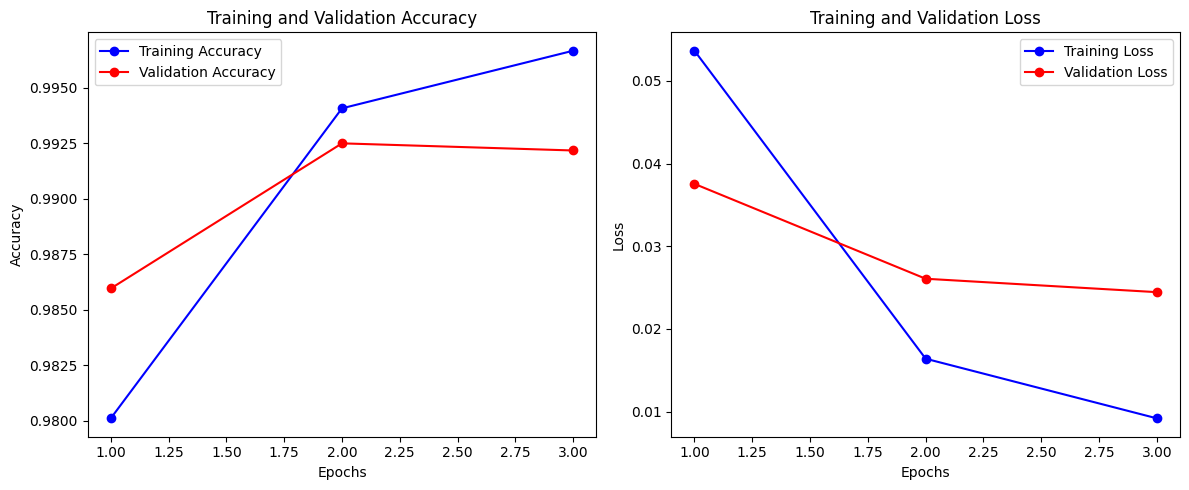

In [12]:
# Plot training and validation accuracy/loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

The divergence between training and validation accuracy by epoch 3 suggests the model might be starting to overfit — performing better on training data but not improving (or slightly worsening) on unseen validation data.

In [10]:
# Save the model
model.save_pretrained(f'{model_dir}')
tokenizer.save_pretrained(f'{model_dir}')

('./E1/model/tokenizer_config.json',
 './E1/model/special_tokens_map.json',
 './E1/model/vocab.txt',
 './E1/model/added_tokens.json')

In [10]:
# Show the model architecture
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


584/584 [==============================] - 1084s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5193
           1       0.99      1.00      0.99      4137

    accuracy                           0.99      9330
   macro avg       0.99      0.99      0.99      9330
weighted avg       0.99      0.99      0.99      9330



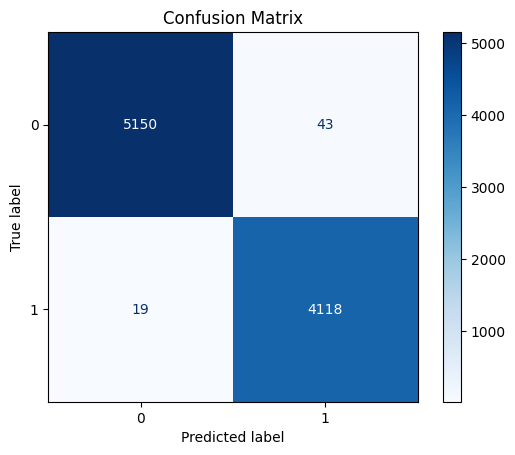

In [6]:
# Performance Evaluation

# Get raw logits from model
logits = model.predict(test_dataset).logits

# Convert logits to predicted class labels
y_pred = np.argmax(logits, axis=1)

# Get true labels from test set
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Print classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Perform Error Analysis

Error analysis helps us determine which part of the process we need to tweak to give the biggest improvement. Likewise, it helps us avoid focusing on parts that do not greatly affect the results.

Let's look at the data that the model incorrectly predicted.

In [7]:
test_df_copy = pd.concat([test_df.reset_index(drop=True), pd.Series(y_pred).rename('label_pred')], axis=1)

false_negatives = test_df_copy[(test_df_copy['label']!=test_df_copy['label_pred'])&(test_df_copy['label']==1)].reset_index(drop=True)
false_positives = test_df_copy[(test_df_copy['label']!=test_df_copy['label_pred'])&(test_df_copy['label']==0)].reset_index(drop=True)

print('Here are false negatives:')
for i in false_negatives['text']:
    print(i, '\n===== END OF THIS NEWS ===== \n')
print('')
print('Here are false positives:')
for i in false_positives['text']:
    print(i, '\n===== END OF THIS NEWS ===== \n')

Here are false negatives:
We are supposed to have a government of the people, by the people and for the people, but instead we have a government of the elite, by the elite and for the elite. Most people do not realize this, but today most members of Congress are actually millionaires. The disconnect between members of Congress and average Americans has never been greater than it is right now, and I think that is a very troubling sign for the future of this nation.Sen. Ted Cruz (R-Texas) and Rep. Ron DeSantis (R-Fla.) are pushing for an amendment to the Constitution to place term limits on lawmakers, arguing the move will help overhaul Washington. The American people resoundingly agreed on Election Day, and President-elect Donald Trump has committed to putting government back to work for the American people,  Cruz said in a statement on Tuesday.  It is well past time to put an end to the cronyism and deceit that has transformed Washington into a graveyard of good intentions. Under an am

The model is technically excellent and potentially MORE accurate than the training labels. The high accuracy shows it learned the labeling pattern perfectly but the labeling pattern itself might be problematic. Let's look at an example from each of the false negatives and false positives:
1. False Negative Example:
   - "DEAD MUSLIMS SOCIETY will sue to force small Massachusetts town to allocate space for 16,000 dead Muslims... aided and abetted by the litigation jihadists of designated terrorist group CAIR."
   - The model predicted that this is FAKE but the label says it is REAL. The news is indeed FAKE because it has (i) inflammatory, dehumanizing language ("Dead Muslims Society"), (ii) loaded terms ("litigation jihadists", "designated terrorist group"), (iii) sensationalized framing designed to provoke fear/anger.
   - The dataset likely labeled this as "real" because it references an actual news event (a cemetery dispute in Massachusetts). But the article's presentation is so distorted and inflammatory that it crosses into misinformation territory.
   - The label conflates "based on a real event" with "trustworthy reporting." The model correctly identified this as fake news based on its manipulative language patterns.
2. False Positive Example:
   - "When Donald Trump began his improbable run for president 15 months ago... it became clear that Mr. Trump's views were matters of dangerous impulse and cynical pandering... It is time for others who are still undecided... to take a hard look and see Mr. Trump for who he is."
   - The model predicted that this is REAL but the label says it is FAKE. The news is indeed REAL because it has (i) professional journalistic writing, (ii) structured argumentation with evidence, (iii) published by established newspaper (NYT) and clearly labeled as editorial/opinion: https://www.nytimes.com/2016/09/26/opinion/why-donald-trump-should-not-be-president.html
   - The dataset appears to have labeled opinion content against Trump as "fake news," possibly because the source list conflated anti-Trump content with misinformation.
   - This is legitimate opinion journalism from one of the world's most respected newspapers. Labeling it "fake" because it's critical of Trump may be revealing political bias in the dataset labeling.

These examples show the model is learning to detect actual fake news characteristics (manipulative language, sensationalism, inflammatory framing) rather than just memorizing source labels. But it's being penalized because the dataset:
- Labels inflammatory misinformation as "real"
- Labels legitimate mainstream opinion as "fake"

The 99% accuracy is impressive, but these errors suggest the remaining 1% might actually be the model being too smart and correcting the dataset's mistakes. The data-centric approach where the model code is held fixed and the data are improved iteratively should be followed in the next iterations.

The labelling process should be investigated. Critical questions to address:
1. How does the dataset handle:
   - Opinion vs. news distinction
   - Partisan but factual reporting
   - Legitimate controversial topics
2. What is the actual labeling methodology?
   - Who determined which sources are "fake"?
   - Were articles independently fact-checked?

### Further Considerations

* Establishing a performance baseline would allow us to better understand whether our prototype model is a major improvement to what is already available, and if so, by how much.
* Adding more data would likely help boost the model's performance, if possible. We can try getting training examples from other datasets to see if having more diverse examples will help the model pick up more patterns.
* We can try training the data with more complex architecture to see whether this would help boost the model performance.

<a id='deployment'></a>
## 4. Deployment

Given that the prototype model performs well and it may take too much time to improve the data quality for the current needs, let's deploy the prototype model and start receiving requests. This can open up new challenges, and we will have to monitor potential problems and make sure that the model stays performant.

In [12]:
# Packages needed in the Deployment Stage

import os
import requests
import json

Let's deploy the model locally using Tensorflow Serving, which can be installed by following [the instructions here](https://www.tensorflow.org/tfx/serving/setup). Alternatively, we can use Docker and/or deploy on a cloud platform if we need to process news articles in batches every hour.

In [13]:
SERVING_DIR = f'{os.getcwd()}/serving'
os.environ["SERVING_DIR"] = SERVING_DIR

print(f'SERVING_DIR: {SERVING_DIR}')
print(f'os.environ["SERVING_DIR"]: {os.environ["SERVING_DIR"]}')

SERVING_DIR: /mnt/c/Users/onatz/Downloads/fake_news_project/serving
os.environ["SERVING_DIR"]: /mnt/c/Users/onatz/Downloads/fake_news_project/serving


In [14]:
# Save the model to the serving directory
model.save(f'{SERVING_DIR}/1')

INFO:tensorflow:Assets written to: /mnt/c/Users/onatz/Downloads/fake_news_project/serving/1/assets


INFO:tensorflow:Assets written to: /mnt/c/Users/onatz/Downloads/fake_news_project/serving/1/assets


Let's run Tensorflow Serving in the background and it will detect the model available for serving.

In [15]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fakenews_model \
  --model_base_path="${SERVING_DIR}" > ./serving/server.log 2>&1

One of the things we want to ensure when serving models is consistency in data transformations. The inference data must follow the same transformation pipeline as the training data. We implemented a Flask wrapper that allows passing a string directly to the model. To enable this, run the Flask wrapper in the terminal: `python tokenizer_server.py`

Then, let's send two requests to the model: one for a real news article and another for a fake one. We will get a response with the predictions.

In [20]:
response = requests.post(
    'http://localhost:5000/predict', 
    json={"text": "Trump Considers Overhaul of Refugee System That Would Favor White People. The proposals would transform a program aimed at helping the most vulnerable people in the world into one that gives preference to mostly white people who say they are being persecuted."}
)

print(response.json())

{'predictions': [[-3.20628476, 3.30672503]]}


In [21]:
# Convert the logits to probabilities

logits = np.array(response.json()['predictions'][0])
probs = np.exp(logits) / np.sum(np.exp(logits))

print(f"Class 0 probability: {probs[0]:.4f}")
print(f"Class 1 probability: {probs[1]:.4f}")
print(f"Predicted class: {np.argmax(logits)}")

# this is indeed a real news article: https://www.nytimes.com/2025/10/15/us/politics/trump-refugee-white-people.html

Class 0 probability: 0.0015
Class 1 probability: 0.9985
Predicted class: 1


In [30]:
response = requests.post(
    'http://localhost:5000/predict',
    json={"text": "“At that point officials will decide whether to bring it back for Columbus Day weekend when crowds of automobiles once again make driving here almost impossible. It has already been decided to bring it back for the summer of 2025. The Hamptons’ faux fee would depend on the vehicle’s price tag, with cars “with low value, such as old Toyota Corollas,” paying just $5, but cars worth up to $60,000 forced to pay $50. Cars valued at up to $100,000 would pay $200, with vehicles worth and between $100,000 and $250,000 having to pay $999."}
)

print(response.json())

{'predictions': [[2.29810452, -2.05049086]]}


In [31]:
# Convert the logits to probabilities

logits = np.array(response.json()['predictions'][0])
probs = np.exp(logits) / np.sum(np.exp(logits))

print(f"Class 0 probability: {probs[0]:.4f}")
print(f"Class 1 probability: {probs[1]:.4f}")
print(f"Predicted class: {np.argmax(logits)}")

# this is indeed a fake news article, as described here: https://nypost.com/2024/09/01/us-news/spoof-article-about-supposed-congestion-pricing-in-hamptons-drives-locals-crazy/

Class 0 probability: 0.9872
Class 1 probability: 0.0128
Predicted class: 0


### Monitor and Maintain System

If the model goes live in production, we will want to know as early as possible if there's a problem. We need to brainstorm potential issues and develop metrics to detect them. We can set up an alarm if a threshold is met, so we can investigate. Metrics can be broadly classified into three categories:

* Software metrics - These refer to the capacity of the platform to deliver the prediction service. It includes measuring available memory and compute resources, latency, throughput, and server load. These metrics will indicate whether resources need to be scaled to maintain system performance.

* Input metrics - These refer to the characteristics of the incoming data, to detect if the input distribution is changing or if there are edge cases that were not considered. For example, average input length, number of unknown tokens, out-of-vocabulary words, etc.

* Output metrics - These refer to the results of the model predictions. For example, average number of predictions per category, average probability per prediction, etc.